In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hvplot.pandas

In [2]:
bess_df = pd.read_csv(r"C:\Users\student\Downloads\Bess data task 1.csv")

In [3]:
bess_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 43 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   timestamp                                      4915 non-null   object 
 1   BMU1_total_current [A]                         4915 non-null   float64
 2   BMU1_SOC [%]                                   4915 non-null   float64
 3   BMU1_max_charge_current [A]                    4915 non-null   float64
 4   BMU1_max_disch_current [A]                     4915 non-null   float64
 5   BMU1_max_cell_volt                             4915 non-null   float64
 6   BMU1_min_cell_volt                             4915 non-null   float64
 7   BMU1_SBMU1_max_allowed_charge_current [A]      4915 non-null   float64
 8   BMU1_SBMU1_max_allowed_discharge_current [A]   4915 non-null   float64
 9   BMU1_SBMU1_current [A]                         4915 

In [4]:
bess_df['timestamp'] = pd.to_datetime(bess_df['timestamp'])

In [5]:
bmu1_parameters = bess_df[['BMU1_total_current [A]',
'BMU1_max_charge_current [A]',
'BMU1_max_disch_current [A]',
'BMU1_SOC [%]']]

In [6]:
bmu1_parameters.describe()

,BMU1_total_current [A],BMU1_max_charge_current [A],BMU1_max_disch_current [A],BMU1_SOC [%]
count,4915.000000,4915.000000,4915.000000,4915.000000
mean,112.314954,-1557.713530,1576.000814,54.796541
std,997.432857,94.386827,81.263323,21.127086
min,-1519.000000,-1779.000000,1434.000000,5.100000
25%,-685.000000,-1652.000000,1504.000000,42.600000
50%,7.000000,-1547.000000,1581.000000,57.700000
75%,765.000000,-1479.000000,1653.000000,71.800000
max,1746.000000,-1341.000000,1779.000000,87.000000


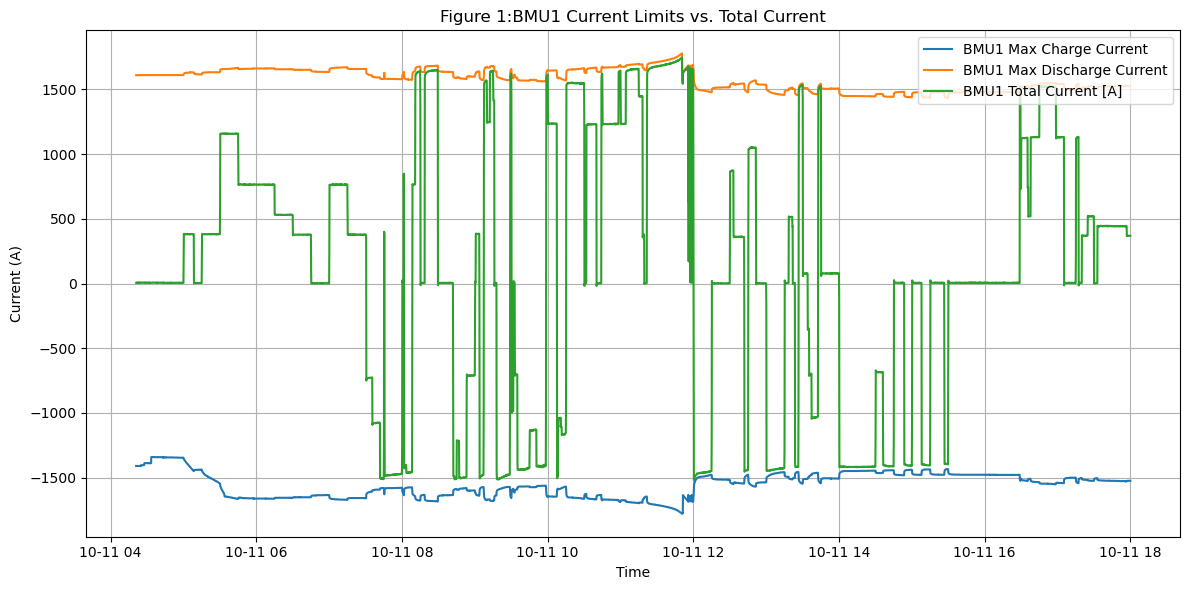

In [7]:
plt.figure(figsize=(12,6))
plt.plot(bess_df['timestamp'], bess_df['BMU1_max_charge_current [A]'], label='BMU1 Max Charge Current')
plt.plot(bess_df['timestamp'], bess_df['BMU1_max_disch_current [A]'], label='BMU1 Max Discharge Current')
plt.plot(bess_df['timestamp'], bess_df['BMU1_total_current [A]'], label='BMU1 Total Current [A]')
plt.title('Figure 1:BMU1 Current Limits vs. Total Current')
plt.xlabel('Time')
plt.ylabel('Current (A)')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

In the BMU1 parameters the data shows that current lies in the limits of charge and discharge current, so
there is no issue with BMU1 parameter

### SOC Trend Analysis

In [8]:
bess_soc = bess_df['BMU1_SOC [%]'].describe()
bess_soc

count    4915.000000
mean       54.796541
std        21.127086
min         5.100000
25%        42.600000
50%        57.700000
75%        71.800000
max        87.000000
Name: BMU1_SOC [%], dtype: float64

In [9]:
bess_df['SOC_diff'] = bess_df['BMU1_SOC [%]'].diff()
flat_soc_periods = (bess_df['SOC_diff'].abs() < 0.01).sum()
flat_soc_periods

np.int64(2043)

In [10]:
flat_with_current = bess_df.loc[(bess_df['SOC_diff'].abs() < 0.01) & (bess_df['BMU1_total_current [A]'].abs()>50)]
print(f"Flat SOC periods during active current flow: {len(flat_with_current)} rows")

Flat SOC periods during active current flow: 744 rows


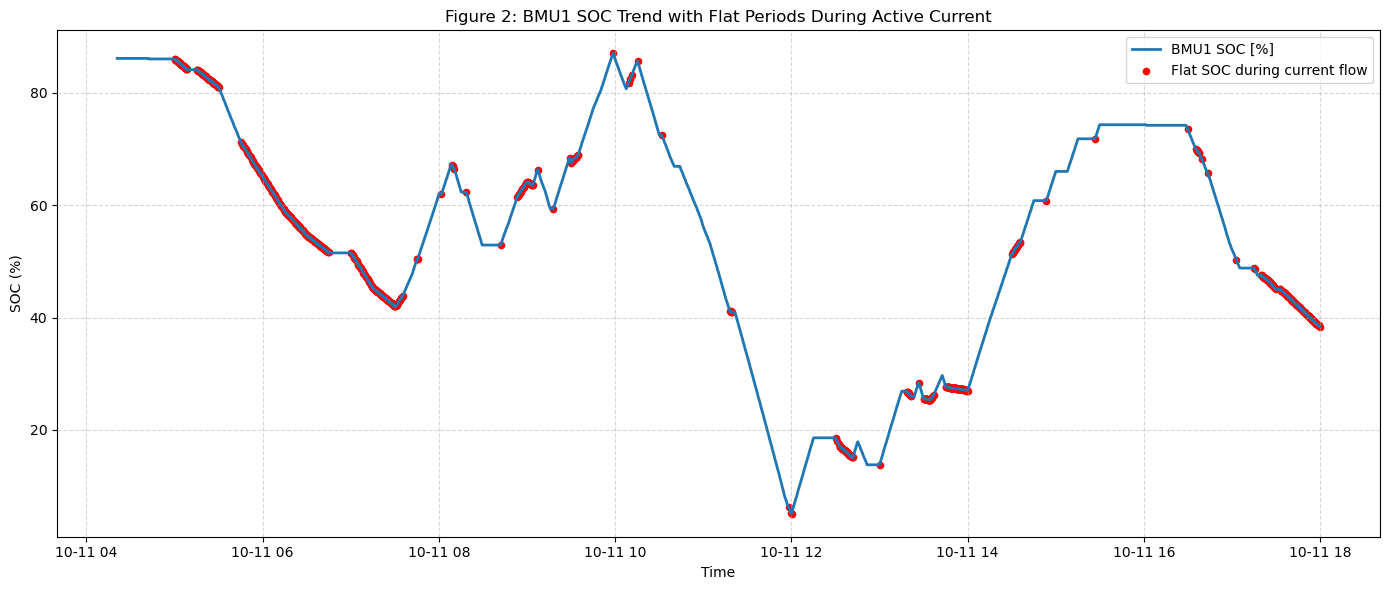

In [11]:
bess_df['flat_SOC_active'] = (
    (bess_df['SOC_diff'].abs() < 0.01) &
    (bess_df['BMU1_total_current [A]'].abs() > 50)  # Use your threshold
)

plt.figure(figsize=(14, 6))
sns.lineplot(
    x='timestamp',
    y='BMU1_SOC [%]',
    data=bess_df,
    label='BMU1 SOC [%]',
    linewidth=2
)
plt.scatter(
    bess_df.loc[bess_df['flat_SOC_active'], 'timestamp'],
    bess_df.loc[bess_df['flat_SOC_active'], 'BMU1_SOC [%]'],
    color='red',
    marker='o',
    s=20,
    label='Flat SOC during current flow'
)

plt.title('Figure 2: BMU1 SOC Trend with Flat Periods During Active Current')
plt.xlabel('Time')
plt.ylabel('SOC (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Operational Issues for SBMU 1-6

In [12]:
def get_sbmu_columns(sbmu):
  current = f'BMU1_SBMU{sbmu}_current [A]'
  charge_max = f'BMU1_SBMU{sbmu}_max_allowed_charge_current [A]'
  discharge_max = f'BMU1_SBMU{sbmu}_max_allowed_discharge_current [A]'
  return current, charge_max, discharge_max

In [13]:
sbmu_1_6 = list(range(1, 7))
issues_sbmu_1_6 = []
for sbmu in sbmu_1_6:
    current, charge_max, discharge_max = get_sbmu_columns(sbmu)
    charge_issue = (bess_df[current] < bess_df[charge_max]).sum()
    discharge_issue = (bess_df[current] > bess_df[discharge_max]).sum()
issues_sbmu_1_6.append({
'SBMU': f'SBMU{sbmu}',
'Charge Violations': charge_issue,
'Discharge Violations': discharge_issue
})
issues_df_1_6 = pd.DataFrame(issues_sbmu_1_6)

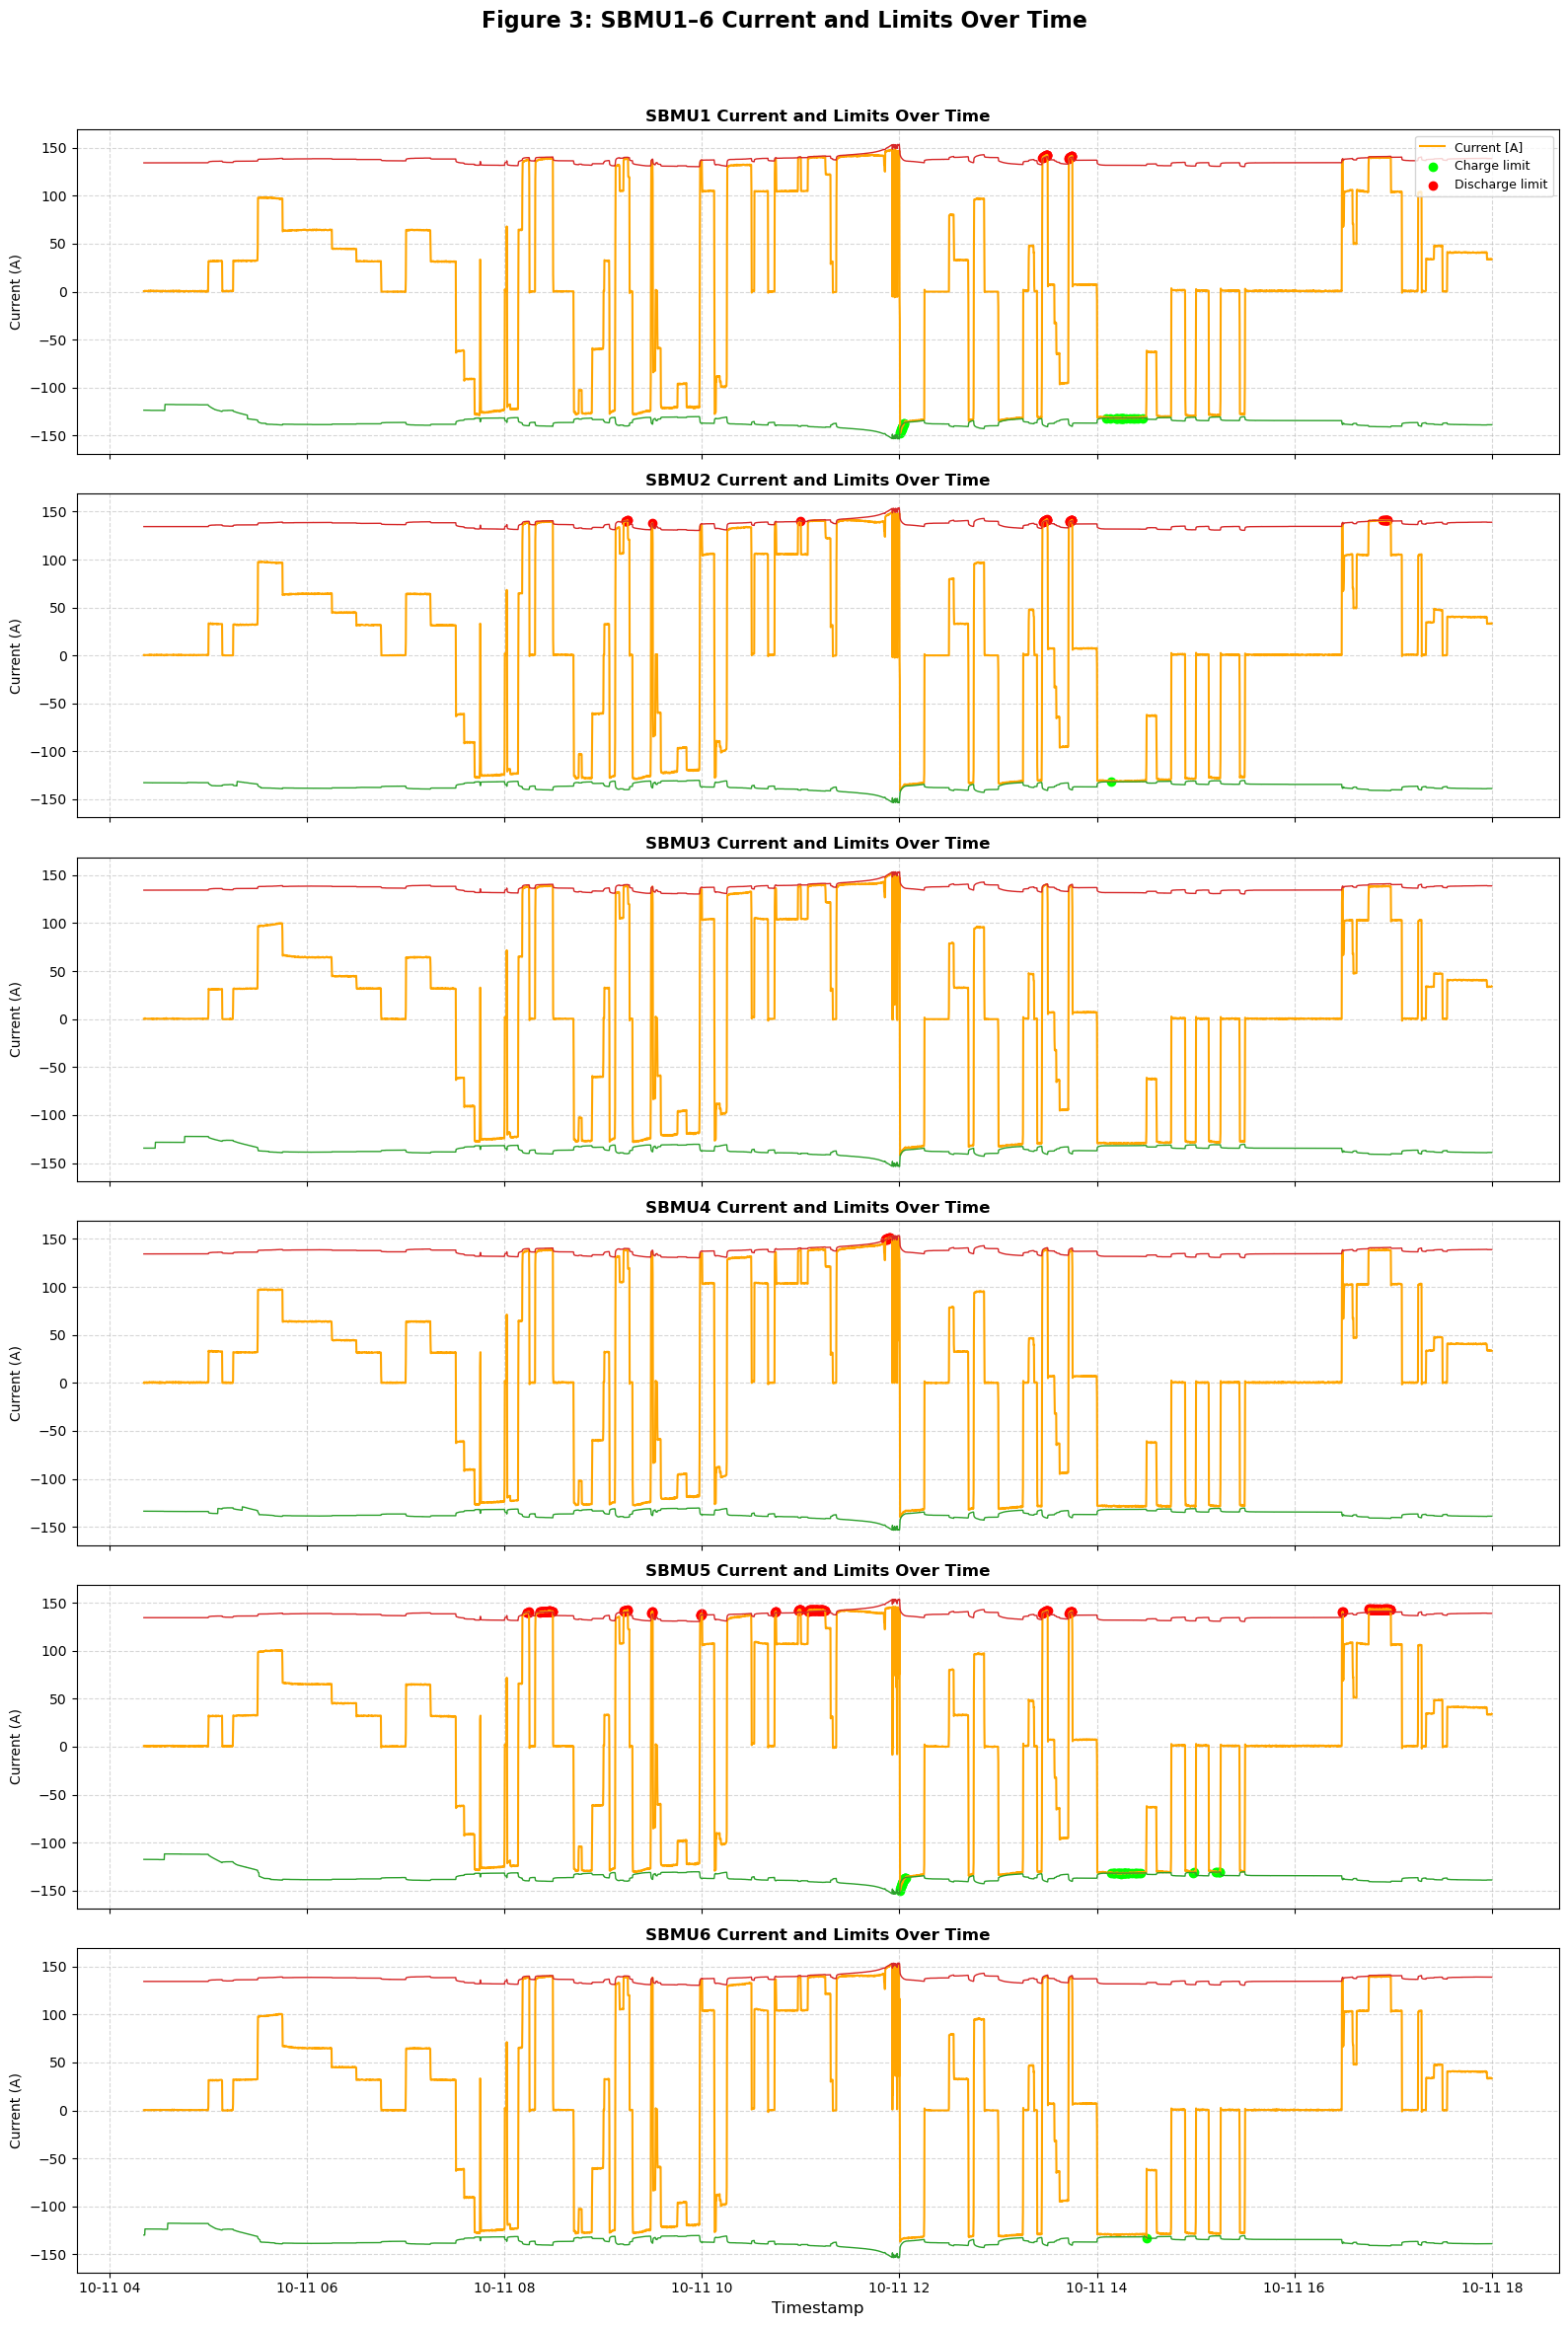

In [14]:
fig, axs = plt.subplots(6, 1, figsize=(16, 24), sharex=True)
for i, sbmu in enumerate(range(1, 7)):
    current, charge_max, discharge_max = get_sbmu_columns(sbmu)
    axs[i].plot(bess_df['timestamp'], bess_df[current], label='Current [A]', color='orange')
    axs[i].plot(bess_df['timestamp'], bess_df[charge_max], color='tab:green', linewidth=1)
    axs[i].plot(bess_df['timestamp'], bess_df[discharge_max], color='tab:red', linewidth=1)
    charge_issue = bess_df[bess_df[current] < bess_df[charge_max]]
    discharge_issue = bess_df[bess_df[current] > bess_df[discharge_max]]
    axs[i].scatter(charge_issue['timestamp'], charge_issue[current], color='lime', label='Charge limit')
    axs[i].scatter(discharge_issue['timestamp'], discharge_issue[current], color='red', label='Discharge limit')
    axs[i].set_title(f'SBMU{sbmu} Current and Limits Over Time', fontsize=12, weight='bold')
    axs[i].set_ylabel('Current (A)')
    axs[i].grid(True, linestyle='--', alpha=0.5)
    if i == 0:
      axs[i].legend(loc='upper right', fontsize=9)
plt.xlabel('Timestamp', fontsize=12)
fig.suptitle('Figure 3: SBMU1–6 Current and Limits Over Time', fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

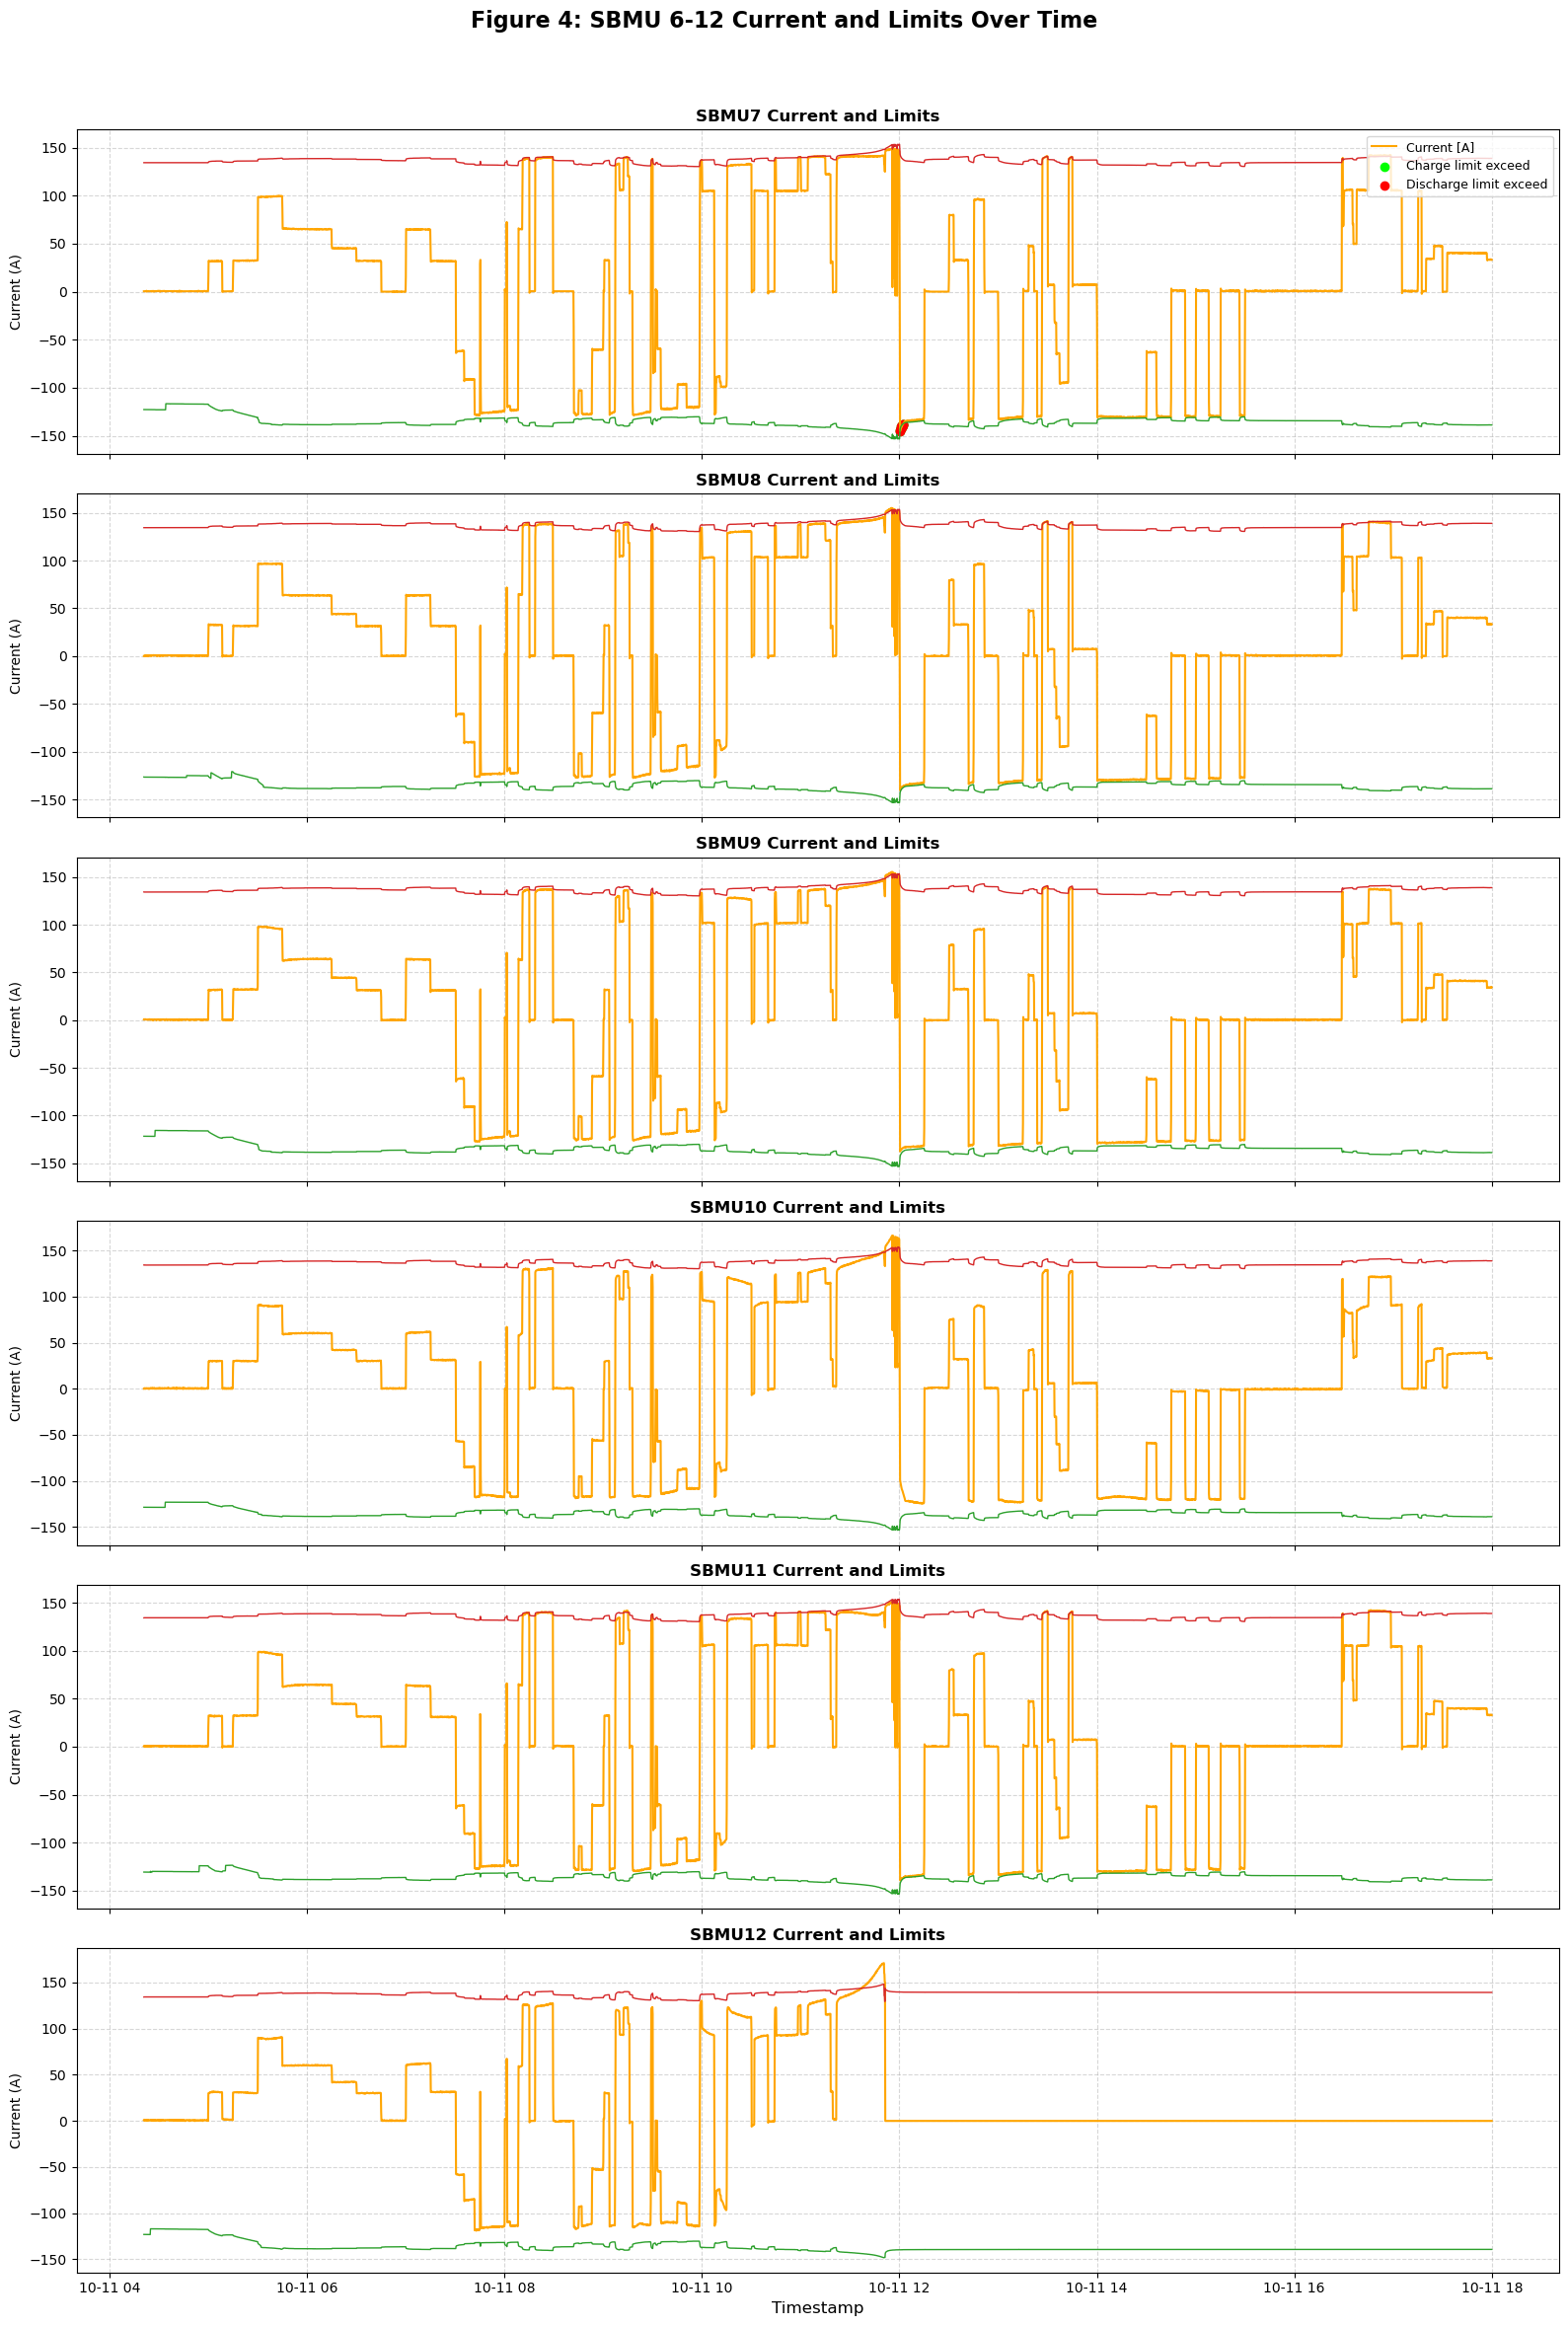

In [15]:
fig, axs = plt.subplots(6, 1, figsize=(16, 24), sharex=True)
for i, sbmu in enumerate(range(7, 13)):
    current, charge_max, discharge_max = get_sbmu_columns(sbmu)
    axs[i].plot(bess_df['timestamp'], bess_df[current], label='Current [A]', color='orange')
    axs[i].plot(bess_df['timestamp'], bess_df[charge_max], color='tab:green', linewidth=1)
    axs[i].plot(bess_df['timestamp'], bess_df[discharge_max], color='tab:red', linewidth=1)
    charge_issue = bess_df[bess_df[current] < bess_df[charge_max]]
    discharge_issue = bess_df[bess_df[current] > bess_df[discharge_max]]
    axs[i].scatter(charge_issue['timestamp'], charge_issue[current], color='lime', label='Charge limit exceed')
    axs[i].scatter(charge_issue['timestamp'], charge_issue[current], color='red', label='Discharge limit exceed')
    axs[i].set_title(f'SBMU{sbmu} Current and Limits', fontsize=12, weight='bold')
    axs[i].set_ylabel('Current (A)')
    axs[i].grid(True, linestyle='--', alpha=0.5)
    if i == 0:
       axs[i].legend(loc='upper right', fontsize=9)
plt.xlabel('Timestamp', fontsize=12)
fig.suptitle('Figure 4: SBMU 6-12 Current and Limits Over Time', fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

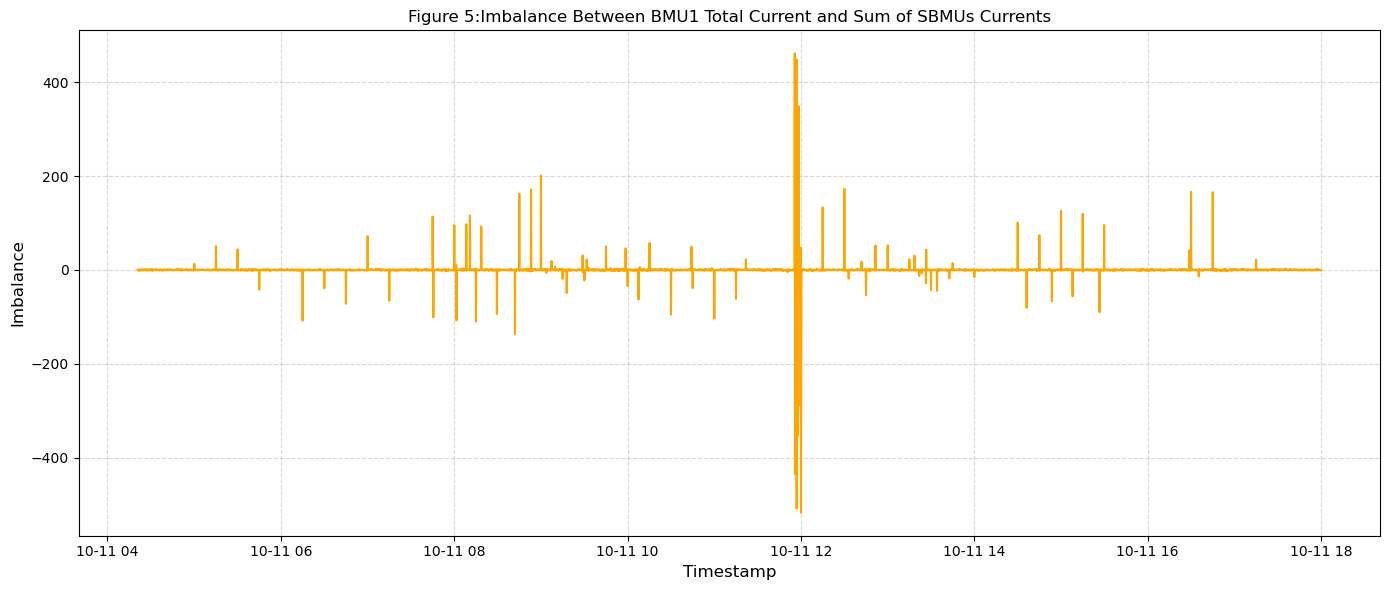

In [16]:
sbmu_current_cols = [f'BMU1_SBMU{i}_current [A]' for i in range(1, 13)]
bess_df['SBMU_total_current'] = bess_df[sbmu_current_cols].sum(axis=1)
bess_df['imbalance'] = bess_df['BMU1_total_current [A]'] - bess_df['SBMU_total_current']
plt.figure(figsize=(14,6))
sns.lineplot(x='timestamp', y='imbalance', data=bess_df, color='orange', linewidth=1.5)
plt.title('Figure 5:Imbalance Between BMU1 Total Current and Sum of SBMUs Currents')
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Imbalance', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Task 2

In [17]:
task2 = pd.read_csv(r"C:\Users\student\Documents\BESS_data_task2.csv")

In [18]:
task2.head()

,timestamp,SOC,rack_current,rack_max_temp,rack_min_temp,rack_avg_cell_volt,rack_max_cell_volt,rack_min_cell_volt,rack_voltage_deviation_mV
0,2024-12-09 00:00:08.075000+00:00,7.6,0.7,23.1,19.3,3.452,3.472,3.406,66.0
1,2024-12-09 00:00:37.993000+00:00,7.5,0.7,23.1,19.3,3.451,3.471,3.406,65.0
2,2024-12-09 00:01:08.054000+00:00,7.6,-0.2,23.1,19.3,3.452,3.473,3.407,66.0
3,2024-12-09 00:01:37.974000+00:00,7.5,0.7,23.1,19.3,3.451,3.471,3.406,65.0
4,2024-12-09 00:02:08.043000+00:00,7.6,-0.3,23.1,19.3,3.452,3.472,3.406,66.0


In [19]:
task2.isnull().sum()

timestamp                    0
SOC                          0
rack_current                 0
rack_max_temp                0
rack_min_temp                0
rack_avg_cell_volt           0
rack_max_cell_volt           0
rack_min_cell_volt           0
rack_voltage_deviation_mV    0
dtype: int64

In [20]:
task2['timestamp'] = pd.to_datetime(task2['timestamp'],format='mixed')

In [21]:
task2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78425 entries, 0 to 78424
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   timestamp                  78425 non-null  datetime64[ns, UTC]
 1   SOC                        78425 non-null  float64            
 2   rack_current               78425 non-null  float64            
 3   rack_max_temp              78425 non-null  float64            
 4   rack_min_temp              78425 non-null  float64            
 5   rack_avg_cell_volt         78425 non-null  float64            
 6   rack_max_cell_volt         78425 non-null  float64            
 7   rack_min_cell_volt         78425 non-null  float64            
 8   rack_voltage_deviation_mV  78425 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(8)
memory usage: 5.4 MB


In [22]:
task2['timestamp'].dtype

datetime64[ns, UTC]

In [23]:
task2.set_index('timestamp',inplace=True)

In [24]:
task2.describe()

,SOC,rack_current,rack_max_temp,rack_min_temp,rack_avg_cell_volt,rack_max_cell_volt,rack_min_cell_volt,rack_voltage_deviation_mV
count,78425.000000,78425.000000,78425.000000,78425.000000,78425.000000,78425.000000,78425.000000,78425.000000
mean,8.533844,-0.020199,23.296323,19.610613,3.482515,3.504601,3.457810,46.791202
std,11.449383,5.288553,0.726389,0.633412,0.077860,0.079228,0.077947,9.564525
min,3.400000,-44.500000,22.400000,18.600000,3.416000,3.445000,3.365000,19.000000
25%,4.100000,-0.200000,22.900000,19.200000,3.454000,3.475000,3.431000,43.000000
50%,4.800000,0.000000,23.100000,19.400000,3.456000,3.477000,3.433000,44.000000
75%,6.100000,0.200000,23.400000,19.700000,3.459000,3.480000,3.436000,46.000000
max,90.900000,35.000000,27.000000,23.200000,4.092000,4.136000,4.050000,94.000000


In [25]:
task2.head()

,SOC,rack_current,rack_max_temp,rack_min_temp,rack_avg_cell_volt,rack_max_cell_volt,rack_min_cell_volt,rack_voltage_deviation_mV
timestamp,,,,,,,,
2024-12-09 00:00:08.075000+00:00,7.6,0.7,23.1,19.3,3.452,3.472,3.406,66.0
2024-12-09 00:00:37.993000+00:00,7.5,0.7,23.1,19.3,3.451,3.471,3.406,65.0
2024-12-09 00:01:08.054000+00:00,7.6,-0.2,23.1,19.3,3.452,3.473,3.407,66.0
2024-12-09 00:01:37.974000+00:00,7.5,0.7,23.1,19.3,3.451,3.471,3.406,65.0
2024-12-09 00:02:08.043000+00:00,7.6,-0.3,23.1,19.3,3.452,3.472,3.406,66.0


In [26]:
task2['warning'] = (task2['SOC']>=10) & (task2['rack_voltage_deviation_mV'] >= 50)

In [27]:
warning_activated = task2.query("SOC >= 10 & rack_voltage_deviation_mV >= 50")

In [28]:
warning_activated.sum()

SOC                          191683.500
rack_current                     -3.800
rack_max_temp                145300.800
rack_min_temp                122142.100
rack_avg_cell_volt            22153.753
rack_max_cell_volt            22360.076
rack_min_cell_volt            21968.965
rack_voltage_deviation_mV    391111.000
warning                        6085.000
dtype: float64

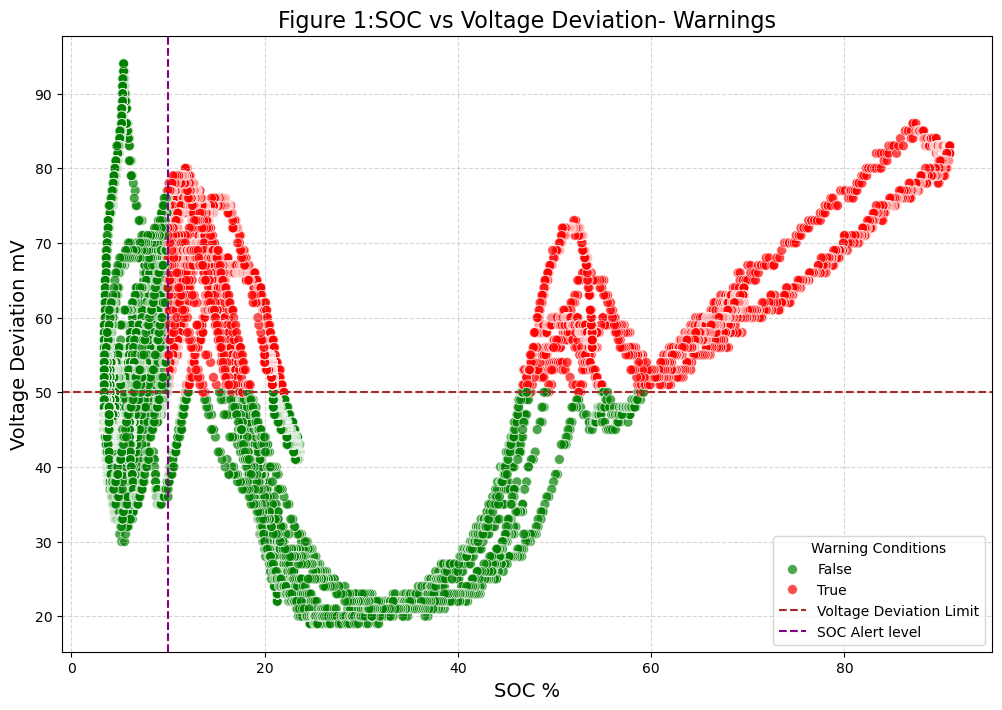

In [29]:
plt.figure(figsize=(12,8))
scatter = sns.scatterplot(
    data=task2,
    x='SOC',
    y='rack_voltage_deviation_mV',
    hue='warning',
    palette={True:'red',False:'green'},
    alpha=0.7,
    s=50)

plt.axhline(50, color='brown', linestyle='--', linewidth=1.5, label='Voltage Deviation Limit')
plt.axvline(10, color='purple', linestyle='--', linewidth=1.5, label='SOC Alert level')
plt.xlabel('SOC %', fontsize=14)
plt.ylabel('Voltage Deviation mV', fontsize=14)
plt.title('Figure 1:SOC vs Voltage Deviation- Warnings', fontsize=16)
plt.legend(title='Warning Conditions', loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

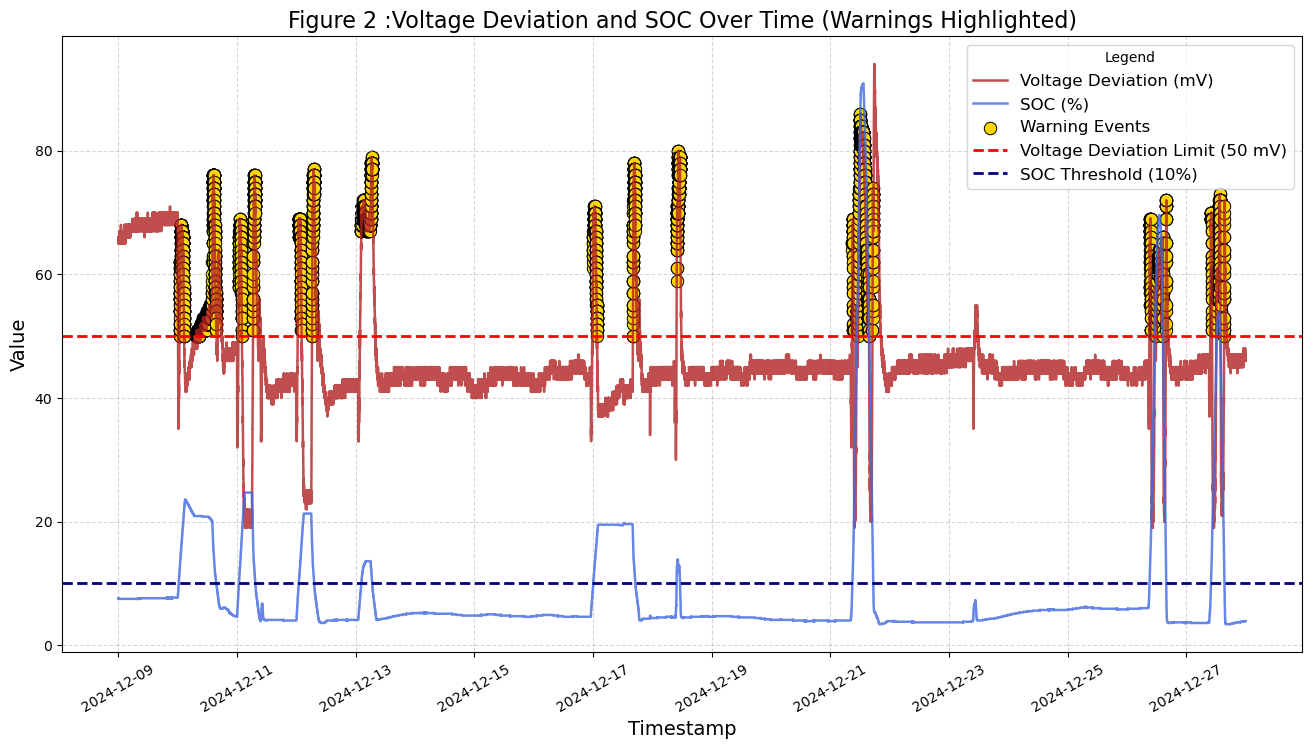

In [30]:
plt.figure(figsize=(16,8))
sns.lineplot(
data=task2,
x=task2.index,
y='rack_voltage_deviation_mV',
label='Voltage Deviation (mV)',
alpha=0.8,
color='firebrick',
linewidth=1.8)
sns.lineplot(
data=task2,
x=task2.index,
y='SOC',
label='SOC (%)',
alpha=0.8,
color='royalblue',
linewidth=1.8)
sns.scatterplot(
x=task2[task2['warning']].index,
y=task2[task2['warning']]['rack_voltage_deviation_mV'],
color='gold',
s=80,
edgecolor='black',
label='Warning Events')
plt.axhline(50, color='red', linestyle='--', linewidth=2, label='Voltage Deviation Limit (50 mV)')
plt.axhline(10, color='navy', linestyle='--', linewidth=2, label='SOC Threshold (10%)')
plt.xlabel('Timestamp', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Figure 2 :Voltage Deviation and SOC Over Time (Warnings Highlighted)', fontsize=16)
plt.legend(title='Legend', loc='upper right', fontsize=12)
plt.xticks(rotation=30)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [31]:
warning_activated.describe()

,SOC,rack_current,rack_max_temp,rack_min_temp,rack_avg_cell_volt,rack_max_cell_volt,rack_min_cell_volt,rack_voltage_deviation_mV
count,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000
mean,31.500986,-0.000624,23.878521,20.072654,3.640715,3.674622,3.610348,64.274610
std,25.764454,11.867684,1.260092,1.232949,0.163477,0.163072,0.161263,8.916739
min,10.000000,-44.500000,22.500000,18.700000,3.437000,3.475000,3.408000,50.000000
25%,13.100000,-5.900000,22.900000,19.100000,3.536000,3.574000,3.506000,56.000000
50%,17.100000,0.000000,23.200000,19.500000,3.565000,3.594000,3.537000,66.000000
75%,53.200000,5.700000,25.100000,21.400000,3.742000,3.771000,3.712000,70.000000
max,90.900000,34.000000,27.000000,23.200000,4.092000,4.136000,4.050000,86.000000


In [32]:
warnings_per_day = warning_activated.resample('D').size()

In [33]:
warnings_per_day

timestamp
2024-12-10 00:00:00+00:00    1482
2024-12-11 00:00:00+00:00     403
2024-12-12 00:00:00+00:00     387
2024-12-13 00:00:00+00:00     755
2024-12-14 00:00:00+00:00       0
2024-12-15 00:00:00+00:00       0
2024-12-16 00:00:00+00:00       0
2024-12-17 00:00:00+00:00     457
2024-12-18 00:00:00+00:00     273
2024-12-19 00:00:00+00:00       0
2024-12-20 00:00:00+00:00       0
2024-12-21 00:00:00+00:00    1086
2024-12-22 00:00:00+00:00       0
2024-12-23 00:00:00+00:00       0
2024-12-24 00:00:00+00:00       0
2024-12-25 00:00:00+00:00       0
2024-12-26 00:00:00+00:00     780
2024-12-27 00:00:00+00:00     462
Freq: D, dtype: int64

In [34]:
warning_activated.columns

Index(['SOC', 'rack_current', 'rack_max_temp', 'rack_min_temp',
       'rack_avg_cell_volt', 'rack_max_cell_volt', 'rack_min_cell_volt',
       'rack_voltage_deviation_mV', 'warning'],
      dtype='object')

In [37]:
warnings_activated = warning_activated.reset_index()

In [38]:
warnings_activated['SOC_no'] = pd.cut(
    warnings_activated['SOC'],
    bins=[10,20,30,40,50,60,70,80,90,100]
)

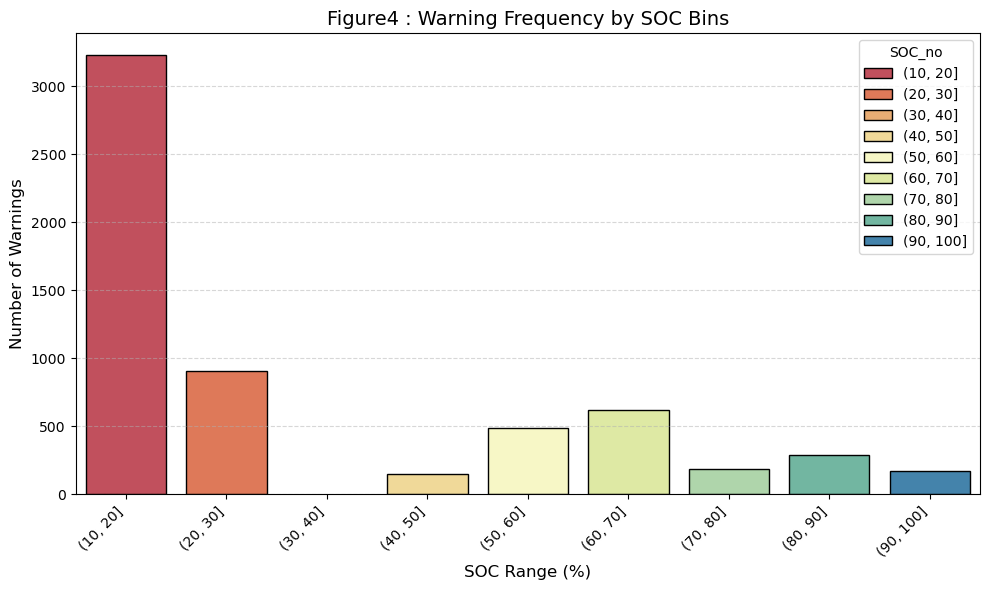

In [39]:
plt.figure(figsize=(10,6))
sns.countplot(
data=warnings_activated,
x='SOC_no',
hue='SOC_no',
palette='Spectral',
dodge=False,
edgecolor='black'
)
plt.xlabel('SOC Range (%)', fontsize=12)
plt.ylabel('Number of Warnings', fontsize=12)
plt.title('Figure4 : Warning Frequency by SOC Bins', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

- from the above graph, we can find out that in the rack the warnings are activated mainly at low SOC levels
10-20 % - The frequency of the warnings decreases as the SOC increases. - very few warnings above 30%
suggesting that cell balance is better at higher SOC or the rack does not reach high SOC often.

In [40]:
warnings_activated_day = warning_activated.resample('D').size()

In [41]:
warnings_activated_day.describe

<bound method NDFrame.describe of timestamp
2024-12-10 00:00:00+00:00    1482
2024-12-11 00:00:00+00:00     403
2024-12-12 00:00:00+00:00     387
2024-12-13 00:00:00+00:00     755
2024-12-14 00:00:00+00:00       0
2024-12-15 00:00:00+00:00       0
2024-12-16 00:00:00+00:00       0
2024-12-17 00:00:00+00:00     457
2024-12-18 00:00:00+00:00     273
2024-12-19 00:00:00+00:00       0
2024-12-20 00:00:00+00:00       0
2024-12-21 00:00:00+00:00    1086
2024-12-22 00:00:00+00:00       0
2024-12-23 00:00:00+00:00       0
2024-12-24 00:00:00+00:00       0
2024-12-25 00:00:00+00:00       0
2024-12-26 00:00:00+00:00     780
2024-12-27 00:00:00+00:00     462
Freq: D, dtype: int64>

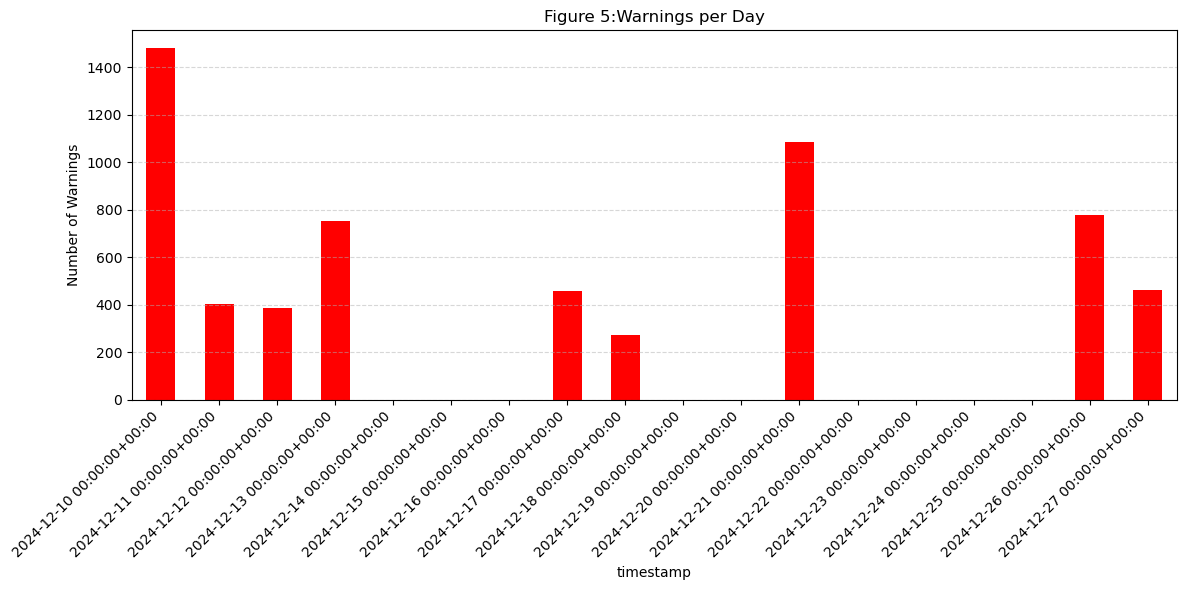

In [42]:
plt.figure(figsize=(12,6))
warnings_per_day.plot(kind='bar', color='red')
plt.ylabel('Number of Warnings')
plt.title('Figure 5:Warnings per Day')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

- From the graph we can see that warnings are not uniformly distributed. On some days there are high
number of warnings and some days there are less warnings or no warnings at all. - Days with no warnings
indicates that the cells were relatively balanced or the system did not operates above 10% of SOC.

## Operational issues identified
- Cell voltage imbalance in the battery rack that are causing warnings.
- There is high voltage deviation above the threshold value of the voltage
deviation and the SOC, therefore this is causing constant BMS warnings.
- This imbalance can cause cell degradation and also it can impact safety if the
battery rack.

# Description of the issues with the supporting graphs.
- Voltage Deviation Increases at High SOC
Figure 1 named SOC vs Voltage Deviation Scatter plot of the task2 shows
that there is low voltage deviation at low SOC. The most warnings activated
are in the between 10-30% SOC.
Warnings in the red points appear primarily in the low to mid SOC range,
this confirms that the imbalance issues arises after initial discharge.
- Warnings Over Time -Figure 2 named Voltage Deviation and SOC over Time
shows that there is cyclic warnings in voltage deviation red scatter plot
coinciding with the SOC.
Since warnigs are aligning with the high voltage deviation , this confirms
that there is an repeated imbalance issue in each cycle.
- Warnings frequency by SOCthe bar chart shows most warnings occur in the 10-20% SOC range, which
confirms that in the battery rack system the warnings are generated mainly
after the inital discharge.
- Warnings per day
The Figure 5 shows that day by day the number of warnings are not
uniformly distributed.

# Issue Analysis and Recommendations
- I think that maybe the cell aging or internal resistance is causing the issue
during the discharge
- In the given battery rack system the system is not balancing.
- Temperature is not the main cause here , therefore the issue is not due to
overheating, its mainly due to the cell aging.
## Issue recommendation
- I think , if it is possible we should replace the weak module because the
imbalance is repeating.
- We can also increase the balancing current.
- Apart from this we should implement reqular monitoring for voltage
deviation and warning patterns.